In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance_matrix

import timeit
#import emachine as EM

# import data processing and general DCA_ER tools
from pathlib import Path
np.random.seed(1)




In [2]:
data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir


pdb_path = "/pdb/pdb/"
dir_path = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/di/"
ks_path = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/metrics/"


In [3]:
PMF_di_files = list(Path(out_dir).rglob("*PMF*"))
PMF_di_files_str = [str(os.path.basename(path)) for path in PMF_di_files]
PMF_pdb_ids = [di_str[:4] for di_str in PMF_di_files_str]
PMF_pfam_ids = [di_str[5:12] for di_str in PMF_di_files_str]

MF_di_files = list(Path(out_dir).rglob("*_MF*"))
MF_di_files_str = [str(os.path.basename(path)) for path in MF_di_files]
MF_pdb_ids = [di_str[:4] for di_str in MF_di_files_str]
MF_pfam_ids = [di_str[5:12] for di_str in MF_di_files_str]

dp_files = list(Path(out_metric_dir).rglob("*_dp_*"))
dp_files_str = [str(os.path.basename(path)) for path in dp_files]
dp_pdb_ids = [di_str[:4] for di_str in dp_files_str]
dp_pfam_ids = [di_str[5:12] for di_str in dp_files_str]
print(dp_pdb_ids[:5])
print(dp_pfam_ids[:5])
print('DP files: ',len(dp_pdb_ids))


['4cch', '2a96', '3a3w', '7brn', '4als']
['PF00476', 'PF01569', 'PF02126', 'PF02991', 'PF03067']
DP files:  10170


In [4]:
# create dp comparison swarm file


# get intersection of sets
comparison_pdb_str_set = set.intersection(set(MF_pdb_ids), set(PMF_pdb_ids))
#Generate MF-ROC swarm
comparison_pdb_set = [pdb for pdb in comparison_pdb_str_set] # check that file doesent already exist
comparison_pfam_set = [MF_pfam_ids[MF_pdb_ids.index(pdb)] for pdb in comparison_pdb_set]
print(len(comparison_pdb_set))

f = open('%s/data_processing_comparison.swarm' % biowulf_dir,'w')
for i, pdb_id  in enumerate(comparison_pdb_set):    
    pfam_id = comparison_pfam_set[i]
    f.write('source /data/cresswellclayec/conda/etc/profile.d/conda.sh; ')
    f.write('conda activate DCA_ER; ')
    f.write('python run_dp_comparison.py %s %s $SLURM_CPUS_PER_TASK\n'%(pdb_id, pfam_id))
    #f.write('module load singularity; ')
    #f.write('singularity exec -B /data/cresswellclayec/DCA_ER/biowulf/ /data/cresswellclayec/DCA_ER/dca_er.simg python 1main_ER.py %s\n'%(pdb))
f.close()

10546


In [5]:
import pickle
n_cols = []
n_seqs = []
mc = []
ER_mc = []
for i, pdb_id in enumerate(dp_pdb_ids):
    pfam_id = dp_pfam_ids[i]
    try:
        compare_file = "%s/%s_%s_dp_comparison.pkl" % (out_metric_dir, pdb_id, pfam_id)
        with open(compare_file, "rb") as f:
            comparison = pickle.load(f)
        f.close()
        er_compare_file = "%s/%s_%s_method_comparison.pkl" % (out_metric_dir, pdb_id, pfam_id)
        with open(er_compare_file, "rb") as f:
            er_comparison = pickle.load(f)
        f.close()
        pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
        pfam_dimensions = np.load(pfam_dimensions_file)
    except(FileNotFoundError):
        continue
        
    if len(pfam_dimensions)==7:
        [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
    elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
        [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
    elif len(pfam_dimensions)==3:
        [n_col, n_seq, m_eff] = pfam_dimensions
    n_cols.append(n_col)
    n_seqs.append(n_seq)

    mc.append(comparison)
    ER_mc.append(er_comparison)

print(mc[0])

{'MFvsPMF': [(0.15306122448979592, 3.22034831901863e-86), array([[-2.39181597]])]}


In [6]:
c_alpha = {.2:1.073, .14:1.138, .1:1.224, .05:1.358, .025:1.48, .01:1.628, .005:1.731, .001:1.949}
alpha = .001
from scipy.special import comb


# Since we only compare MF and PMF there is only one combo:.. MFvsPMF ..
ks_combo = 'MFvsPMF'
ER_combo = 'PMFvsPLM'

ks_vals = []
p_vals = []
ks_vals_asympt = []
p_vals_asympt = []
z = []
ks_clear = []
er_ks_vals_asympt = []
er_clear = []

for i, ks in enumerate(mc):
    er_ks = ER_mc[i]
    
    ks_crit = c_alpha[alpha] * np.sqrt(2*comb(n_cols[i],2) / comb(n_cols[i],2)**2)
    try:
        ks_vals.append(ks[ks_combo][0])
        p_vals.append(ks[ks_combo][1])
        ks_vals_asympt.append(ks[ks_combo][0][0])
        p_vals_asympt.append(ks[ks_combo][0][1])
        er_ks_vals_asympt.append(er_ks[ER_combo][0][0])
    except(IndexError):
        continue
#     print(ks_vals[-1][0],ks_vals_asympt[-1])
    
    if ks_vals_asympt[-1] >= ks_crit:
        ks_clear.append(True)
    else:
        ks_clear.append(False)
        
    if er_ks_vals_asympt[-1] >= ks_crit:
        er_clear.append(True)
    else:
        er_clear.append(False)
               

ks_clear_vals = [ks for i, ks in enumerate(ks_vals_asympt) if ks_clear[i]] 
ks_Nclear_vals = [ks for i, ks in enumerate(ks_vals_asympt) if not ks_clear[i]] 
er_clear_vals = [ks for i, ks in enumerate(er_ks_vals_asympt) if er_clear[i]] 
er_Nclear_vals = [ks for i, ks in enumerate(er_ks_vals_asympt) if not er_clear[i]] 

print(len(ks_clear_vals))
print(len(ks_Nclear_vals))

print(len(er_clear_vals))
print(len(er_Nclear_vals))

9510
368
9706
172


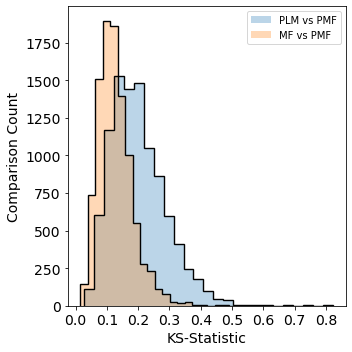

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5.,5.))
ax1=plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)

ax1.hist(er_ks_vals_asympt,bins=25,alpha=.3, label ='PLM vs PMF')  # density=False would make counts
ax1.hist(er_ks_vals_asympt,bins=25,histtype='step', color='k', linewidth=1.4)  # density=False would make counts

ax1.hist(ks_vals_asympt,bins=25,alpha=.3, label ='MF vs PMF')  # density=False would make counts
ax1.hist(ks_vals_asympt,bins=25,histtype='step', color='k', linewidth=1.4)  # density=False would make counts


plt.setp(ax1.get_xticklabels(),fontsize=14)
plt.setp(ax1.get_yticklabels(),fontsize=14)
ax1.set_xlabel('KS-Statistic', fontsize=14)
ax1.set_ylabel('Comparison Count', fontsize=14)
plt.legend()
plt.tight_layout()

plt.savefig('dp_ks_hist.pdf')
plt.show()